In [2]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [3]:
metric_dict = {
    "cola": "eval_matthews_correlation",
    "sst2": "eval_accuracy",
    "stsb": "eval_pearson",
    "qqp": "eval_accuracy",
    "mrpc": "eval_accuracy",
    "mnli": "eval_accuracy",
    "qnli": "eval_accuracy",
    "rte": "eval_accuracy",
}

In [8]:
experiment_dir = "experiments/few_shot_1024_final"
tasks = os.listdir(experiment_dir)

diff_dict = {}

take_last = True

def get_seed(run):
    return int(run.split("_")[-1].split("=")[1])

for task in sorted(tasks):
    runs = [run for run in os.listdir(os.path.join(experiment_dir, task))]
    runs_2 = [run for run in runs if "depth=2" in run]
    runs_3 = [run for run in runs if "depth=3" in run]
    runs_2_results = np.zeros(len(runs_2))
    runs_3_results = np.zeros(len(runs_3))
    for run in runs:
        seed = get_seed(run)
        with open(os.path.join(experiment_dir, task, run, "results.json")) as f:
            results = json.load(f)
        values = [entry['value'] for entry in sorted(results[metric_dict[task]], key=lambda x: x['step'])]
        if "depth=2" in run:
            runs_2_results[seed] = values[-1] if take_last else max(values)
        elif "depth=3" in run:
            runs_3_results[seed] = values[-1] if take_last else max(values)
    diff_dict[task] = runs_3_results - runs_2_results

In [9]:
labels, series = list(zip(*diff_dict.items()))
labels = list(labels)
series = list(series)
series.append(np.array(series).reshape(-1))
labels.append("overall")

In [10]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels, fontsize=12)
    ax.set_xlim(0.25, len(labels) + 0.75)

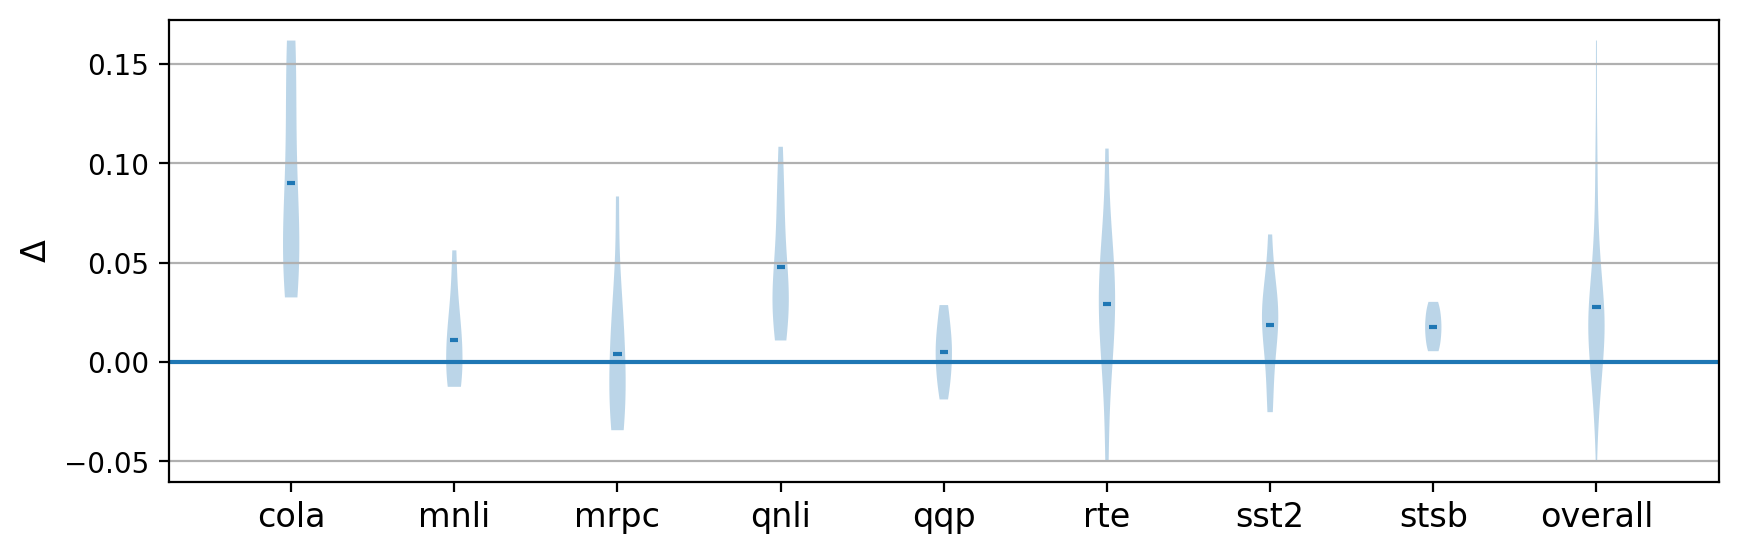

In [14]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.violinplot(series, showmeans=True, showextrema=False, widths=0.1)
ax.yaxis.grid(True)
ax.set_ylabel("$\Delta$", fontsize=12)
ax.hlines(0, 0, 10)

set_axis_style(ax, labels)
fig.savefig("figures/deep_lora_1024.png", bbox_inches="tight", dpi=500)